In [6]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np
from sklearn import tree


In [7]:
data = pd.read_csv('data/dry-bean.csv')

data.head()

data['class'] = pd.Categorical(data['class'])
# data['class_code'] = data['class'].cat.codes

classCodes = dict(enumerate(data['class'].cat.categories))



Splitting data into training / test allows me to test the accuracy of my model on unseend data.

this split is random however to mainatin class raitios i have used stratisfied sampling.

random state = 1 allows randomisation to remain deterministic, this ensures that test data dos not bleed into the training data

In [8]:
X = data.drop(['class'], axis=1)
y = data['class']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=1)
# print(X_train.shape, y_train.shape)


In [9]:
import pickle

filename = "models/dry-bean-nn.pickle"
clf = pickle.load(open(filename, "rb"))


In [93]:
import dice_ml


# Dataset for training an ML model
d = dice_ml.Data(dataframe=data,
                continuous_features=[
                    'Area',
                    'Perimeter',
                    'MajorAxisLength',
                    'MinorAxisLength',
                    'AspectRation',
                    'Eccentricity',
                    'ConvexArea',
                    'EquivDiameter',
                    'Extent',
                    'Solidity',
                    'roundness',
                    'Compactness',
                    'ShapeFactor1',
                    'ShapeFactor2',
                    'ShapeFactor3',
                    'ShapeFactor4'
                   
                ],

                 outcome_name='class')

# Pre-trained ML model
m = dice_ml.Model(model=clf, backend="sklearn", model_type='classifier')
# DiCE explanation instance
exp = dice_ml.Dice(d, m, method="genetic",)


In [94]:
def flattenArray(arr):
    # Create an empty 2D list to hold the converted values
    result = []

    # Loop through each sub-array in the input array
    for sub_arr in arr:
        # Loop through each element in the sub-array
        for element in sub_arr:
            # Append the element to the result list
            result.append(element)

    return result


def lookupClassLabel(array,labels):
    for i in range(len(array)):
        array[i][-1] = labels[array[i][-1]]
    return array


# print(lookupClassLabel(cf["cfs_list"],classCodes))


In [95]:
import json
import csv

counterFactuals = []

percentage_to_sample = 1 / (len(classCodes) - 1) 

# percentage_to_sample = percentage_to_sample * 0.1


f = open('counterfactuals/dry-bean-1.csv', 'w')
first = True
writer = csv.writer(f)
for classCode in classCodes:
    query_instances = data[data["class"].cat.codes ==classCode]
    for desiredClass in classCodes:
        if (desiredClass == classCode):
            continue
        print(
            f" {classCodes[classCode]} => {classCodes[desiredClass]}({percentage_to_sample})")

        result = exp.generate_counterfactuals(
            query_instances.drop(['class'], axis=1).sample(
                frac=percentage_to_sample,random_state=1),
            total_CFs=1, 
            desired_class=int(desiredClass),
            # proximity_weight=0.8,
            # sparsity_weight=0.2, 
            # diversity_weight=0.6, 
            # categorical_penalty=0.1,
            # stopping_threshold=0.4
        )
        result = json.loads(result.to_json())
        cfList = result["cfs_list"]
        cfList = flattenArray(cfList)
        cfList = lookupClassLabel(cfList, classCodes)
        if(first):
            print(result['feature_names_including_target'])
            writer.writerow(result['feature_names_including_target'])
            first = False
        writer.writerows(cfList)




 BARBUNYA => BOMBAY(0.16666666666666666)


100%|██████████| 220/220 [00:51<00:00,  4.27it/s]


['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'class']
 BARBUNYA => CALI(0.16666666666666666)


100%|██████████| 220/220 [01:21<00:00,  2.69it/s]


 BARBUNYA => DERMASON(0.16666666666666666)


  2%|▏         | 4/220 [00:20<18:49,  5.23s/it]

Validate Cfs against model, should get 100% accruracy as these are informed by model

(46, 3)


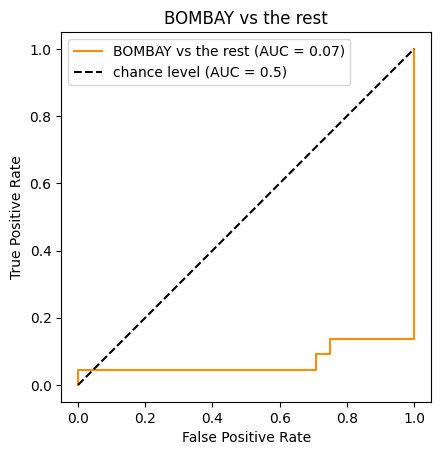

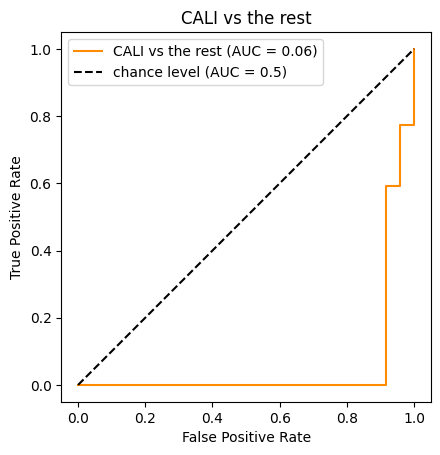

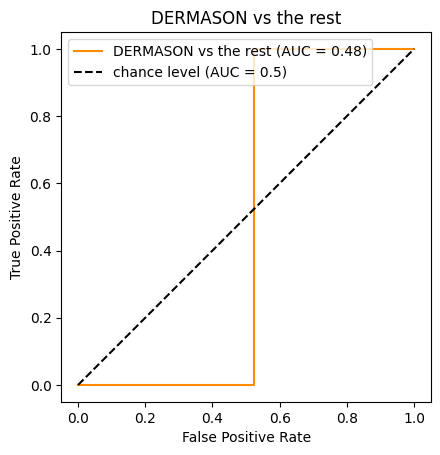

In [79]:
from sklearn.preprocessing import LabelBinarizer


cfdata = pd.read_csv('counterfactuals/dry-bean-1.csv')
# print(cfdata.head())

X = cfdata.drop(['class'], axis=1)
y = cfdata['class']


y_score = clf.predict_proba(X)

label_binarizer = LabelBinarizer().fit(y)
y_onehot_test = label_binarizer.transform(y)
print(y_onehot_test.shape)  # (n_samples, n_classes)

for class_of_interest in label_binarizer.classes_:
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_of_interest} vs the rest")
    plt.legend()
    plt.show()


In [46]:
import random



samples = 1000
rows = {}

headings = list(data.columns.values)



for columnName in headings:
    rows[columnName] = []


for _ in range(samples):


    for columnName in headings:
        # print(columnName, data[columnName].dtype.name)
       
        if (data[columnName].dtype.name == 'category'):
            value = None
        elif (data[columnName].dtype.name == 'float64' ):
            value = random.uniform(
                data[columnName].min(), data[columnName].max())
        elif (data[columnName].dtype.name == 'int64'):
            value = random.uniform(
                data[columnName].min(), data[columnName].max())
        rows[columnName].append(value)

randomData = pd.DataFrame(data=rows, columns=data.columns)

X = randomData.drop(['class'], axis=1) 




randomData['class'] = clf.predict(X)

print(randomData.groupby(['class']).size())



randomData.to_csv('random-pertuabtions/dry-been-100.csv',index=False)


class
BARBUNYA      2
BOMBAY      521
CALI        115
DERMASON      2
HOROZ       357
SEKER         3
dtype: int64


In [47]:
clf.predict(X)


array(['BOMBAY', 'BOMBAY', 'BOMBAY', 'HOROZ', 'BOMBAY', 'HOROZ', 'BOMBAY',
       'HOROZ', 'HOROZ', 'BOMBAY', 'CALI', 'HOROZ', 'CALI', 'BOMBAY',
       'CALI', 'BOMBAY', 'BOMBAY', 'BOMBAY', 'BOMBAY', 'BOMBAY', 'CALI',
       'BOMBAY', 'BOMBAY', 'BOMBAY', 'BOMBAY', 'BOMBAY', 'BOMBAY',
       'HOROZ', 'BOMBAY', 'DERMASON', 'BOMBAY', 'BOMBAY', 'BOMBAY',
       'BOMBAY', 'BOMBAY', 'HOROZ', 'HOROZ', 'HOROZ', 'CALI', 'HOROZ',
       'CALI', 'CALI', 'BOMBAY', 'HOROZ', 'HOROZ', 'HOROZ', 'HOROZ',
       'HOROZ', 'BOMBAY', 'BOMBAY', 'CALI', 'CALI', 'HOROZ', 'BOMBAY',
       'BOMBAY', 'HOROZ', 'CALI', 'HOROZ', 'HOROZ', 'BOMBAY', 'BOMBAY',
       'HOROZ', 'BOMBAY', 'BOMBAY', 'HOROZ', 'HOROZ', 'BOMBAY', 'HOROZ',
       'BOMBAY', 'CALI', 'HOROZ', 'BOMBAY', 'BOMBAY', 'CALI', 'BOMBAY',
       'HOROZ', 'BOMBAY', 'HOROZ', 'BOMBAY', 'BOMBAY', 'BOMBAY', 'HOROZ',
       'BOMBAY', 'HOROZ', 'HOROZ', 'BOMBAY', 'BOMBAY', 'CALI', 'HOROZ',
       'BOMBAY', 'BOMBAY', 'CALI', 'BOMBAY', 'HOROZ', 'BOMBAY', 'CALI',
 